# Optimization of Dissipative Qubit Reset

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
%watermark -v --iversions

qutip       4.3.1
numpy       1.15.4
scipy       1.1.0
matplotlib  3.0.2
matplotlib.pylab  1.15.4
krotov      0.0.1
CPython 3.6.7
IPython 7.1.1


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid #2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

This example provides an example for an optimization in an open quantum system, where the dynamics is governed by the Liouville-von Neumann equation. Hence, states are represented by density matrices $\op{\rho}(t)$ and the time-evolution operator is given by a general dynamical map $\DynMap$.

## Define parameters

In [2]:
omega_q = 1.0  # qubit level splitting
omega_T = 3.0  # TLS level splitting
J       = 0.1  # qubit-TLS coupling
kappa   = 0.04 # TLS decay rate
beta    = 1.0  # inverse bath temperature
T       = 25.0 # final time
nt      = 2500 # number of time steps

## Define the Liouvillian

The system is given by a qubit with Hamiltonian $\op{H}_{q}(t) = - \omega_{q} \op{\sigma}_{z} - \epsilon(t) \op{\sigma}_{z}$, where $\omega_{q}$ is a static energy level splitting which can time-dependently be modified by $\epsilon(t)$. This qubit couples strongly to another two-level system (TLS) with Hamiltonian $\op{H}_{t} = - \omega_{t} \op{\sigma}_{z}$ with static energy level splitting $\omega_{t}$. The coupling strength between both systems is given by $J$ with ther interaction Hamiltonian given by $\op{H}_{int} = J \op{\sigma}_{x} \otimes \op{\sigma}_{x}$. The Hamiltonian for the system of qubit and TLS is

\begin{equation}
  \op{H}(t) = \op{H}_{q}(t) \otimes \identity_{t} + \identity_{q} \otimes \op{H}_{t} + \op{H}_{int}.
\end{equation}

In addition, the TLS is embedded in a heat bath with inverse temperature $\beta$ and couples to that with rate $\kappa$. In order to simulate the dissipation arising from this coupling, we consider the two Lindblad operators $\op{L}_{1} = \sqrt{\kappa (N_{th}+1)} \identity_{q} \otimes \ket{0}\bra{1}$ and $\op{L}_{2} = \sqrt{\kappa N_{th}} \identity_{q} \otimes \ket{1}\bra{0}$ with $N_{th} = 1/(e^{\beta \omega_{t}} - 1)$. The dynamics of the qubit-TLS system state $\op{\rho}(t)$ is than governed by the Liouville-von Neumann equation

\begin{equation}
  \frac{\dd}{\dd t} \op{\rho}(t) =
  \Liouville(t) \op{\rho}(t) =
  - i \left[\op{H}(t), \op{\rho}(t)\right]
  + \sum_{k=1,2} \left(
  \op{L}_{k} \op{\rho}(t) \op{L}_{k}^\dagger
  - \frac{1}{2} \op{L}_{k}^\dagger \op{L}_{k} \op{\rho}(t)
  - \frac{1}{2} \op{\rho}(t) \op{L}_{k}^\dagger \op{L}_{k}
  \right).
\end{equation}

In [3]:
def liou_and_states(omega_q, omega_T, J, kappa, beta):
    """Liouvillian for the coupled system of qubit and TLS"""

    # drift qubit Hamiltonian
    H0_q = 0.5*omega_q*np.diag([-1,1])
    # drive qubit Hamiltonian
    H1_q = 0.5*np.diag([-1,1])

    # drift TLS Hamiltonian
    H0_T = 0.5*omega_T*np.diag([-1,1])

    # Lift Hamiltonians to joint system operators
    H0 = np.kron(H0_q, np.identity(2)) + np.kron(np.identity(2), H0_T)
    H1 = np.kron(H1_q, np.identity(2))

    # qubit-TLS interaction
    #H_int = J*np.fliplr(np.identity(4))
    H_int = J*np.fliplr(np.diag([0,1,1,0]))

    # convert Hamiltonians to QuTiP objects
    H0 = qutip.Qobj(H0+H_int)
    H1 = qutip.Qobj(H1)
    
    # Define Lindblad operators
    N = 1.0/(np.exp(beta*omega_T)-1.0)
    # Cooling on TLS
    L1 = np.sqrt(kappa * (N+1)) * np.kron(np.identity(2), np.array([[0,1],[0,0]]))
    # Heating on TLS
    L2 = np.sqrt(kappa * N) * np.kron(np.identity(2), np.array([[0,0],[1,0]]))

    # convert Lindblad operators to QuTiP objects
    L1 = qutip.Qobj(L1)
    L2 = qutip.Qobj(L2)

    # generate the Liouvillian
    #L0 = qutip.liouvillian(H=H0, c_ops=[L1,L2])
    L0 = qutip.liouvillian(H=H0)
    L1 = qutip.liouvillian(H=H1)

    # define qubit-TLS basis in Hilbert space
    psi_00 = qutip.Qobj(np.kron(np.array([1,0]), np.array([1,0])))
    psi_01 = qutip.Qobj(np.kron(np.array([1,0]), np.array([0,1])))
    psi_10 = qutip.Qobj(np.kron(np.array([0,1]), np.array([1,0])))
    psi_11 = qutip.Qobj(np.kron(np.array([0,1]), np.array([0,1])))

    # take as guess field a filed putting qubit and TLS into resonance
    eps0 = lambda t, args: omega_T - omega_q

    return ([L0, [L1, eps0]], psi_00, psi_01, psi_10, psi_11)

L, psi_00, psi_01, psi_10, psi_11 = liou_and_states(omega_q=omega_q, omega_T=omega_T, J=J, kappa=kappa, beta=beta)

In [4]:
proj_00 = psi_00 * psi_00.dag()
proj_01 = psi_01 * psi_01.dag()
proj_10 = psi_10 * psi_10.dag()
proj_11 = psi_11 * psi_11.dag()

## Define the optimization target

In [5]:
tlist = np.linspace(0, T, nt)

The initial state of qubit and TLS are assumed to be in thermal equilibirum with the heat bath (although only the TLS is directly interacting with the bath). Both states are given by

\begin{equation}
  \op{\rho}_{\alpha}^{th} =
  \frac{e^{x_{\alpha}} \ket{0}\bra{0} + e^{-x_{\alpha}} \ket{1}\bra{1}}{2 \cosh(x_{\alpha})},
  \qquad
  x_{\alpha} = \frac{\omega_{\alpha} \beta}{2},
\end{equation}

with $\alpha = q,t$. The initial state of the bipartite system of qubit and TLS is given by the thermal state $\op{\rho}_{th} = \op{\rho}_{q}^{th} \otimes \op{\rho}_{t}^{th}$.

In [6]:
x_q = omega_q*beta/2.0
rho_q_th = np.diag([np.exp(x_q),np.exp(-x_q)])/(2*np.cosh(x_q))

x_T = omega_T*beta/2.0
rho_T_th = np.diag([np.exp(x_T),np.exp(-x_T)])/(2*np.cosh(x_T))

rho_th = qutip.Qobj(np.kron(rho_q_th, rho_T_th))

Since we are in the end only interested in the state of the qubit, we define `trace_TLS`, which calculates the partial trace over the TLS degrees of freedom. Hence, by passing the state $\op{\rho}$ of the bipartite system of qubit and TLS, it returns the reduced state of the qubit, $\op{\rho}_{q} = \tr_{t}\{\op{\rho}\}$.

In [7]:
def trace_TLS(rho):
    """Partial trace over the TLS degrees of freedom"""
    rho_q = np.zeros(shape=(2,2), dtype=np.complex_)
    rho_q[0,0] = rho[0,0] + rho[1,1]
    rho_q[0,1] = rho[0,2] + rho[1,3]
    rho_q[1,0] = rho[2,0] + rho[3,1]
    rho_q[1,1] = rho[2,2] + rho[3,3]
    return qutip.Qobj(rho_q)

As target state we take (temporarily) the ground state of the bipartite system, i.e., $\op{\rho}_{tgt} = \ket{00}\bra{00}$. Note that in the end we will only optimize the reduced state of the qubit.

In [8]:
rho_q_trg = np.diag([1,0])
rho_T_trg = np.diag([1,0])
rho_trg = np.kron(rho_q_trg, rho_T_trg)
rho_trg = qutip.Qobj(rho_trg)

In [9]:
objectives = [
    krotov.Objective(initial_state=rho_th, target_state=rho_trg, H=L)
]

In the following, we define a shape function $S(t)$.

In [10]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(t, t_start=0, t_stop=T, t_rise=0.05*T, t_fall=0.05*T, func='sinsq')

Shape the field according to $S(t)$ on input.

In [11]:
def shape_field(eps0):
    """Applies the shape function S(t) to the guess field"""
    eps0_shaped = lambda t, args: eps0(t, args)*S(t)
    return eps0_shaped

L[1][1] = shape_field(L[1][1])

OCT parameters.

In [12]:
pulse_options = {
    L[1][1]: krotov.PulseOptions(lambda_a=0.05, shape=S)
}

## Simulate dynamics of the guess field

In [13]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

The following plot shows the guess field $\epsilon_{0}(t)$, which is, as chosen above, just a constant field that puts qubit and TLS into resonance (with a smooth switch-on and switch-off)

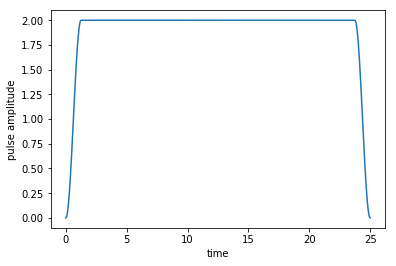

In [14]:
plot_pulse(L[1][1], tlist)

In [15]:
guess_dynamics = objectives[0].mesolve(
    tlist, e_ops=[proj_00, proj_01, proj_10, proj_11])

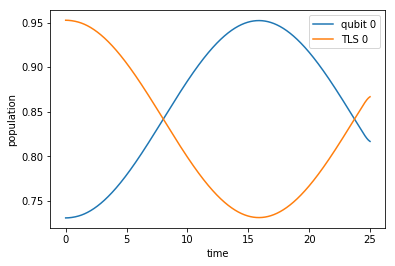

In [16]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, np.array(result.expect[0])+np.array(result.expect[1]), label='qubit 0')
    #ax.plot(result.times, result.expect[2]+result.expect[3], label='qubit 1')
    ax.plot(result.times, np.array(result.expect[0])+np.array(result.expect[2]), label='TLS 0')
    #ax.plot(result.times, result.expect[0], label='00')
    #ax.plot(result.times, result.expect[1], label='01')
    #ax.plot(result.times, result.expect[2], label='10')
    #ax.plot(result.times, result.expect[3], label='11')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)
    
plot_population(guess_dynamics)

We can also verify the propagation using the `expm` propagator that we will be using for the optimization:

In [17]:
guess_dynamics2 = objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm,
    e_ops=[proj_00, proj_01, proj_10, proj_11])

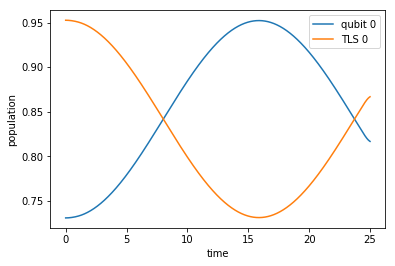

In [18]:
plot_population(guess_dynamics2)

## Optimize

Our optimization target is the groud state $\ket{\Psi}_{q}^{tgt} = \ket{0}$ of the qubit, irrespective of the state of the TLS. Thus, our optimization functional reads

\begin{equation}
  F_{re} = 1 - \Braket{\Psi_{q}^{\tgt}}{\tr_{t}\{\op{\rho}(T)\} \,|\; \Psi_{q}^{\tgt}}
\end{equation}

and we first define `print_qubit_error`, which prints out the above functional after each iteration.

In [19]:
def print_qubit_error(**args):
    """Utility function writing the qubit error to screen"""
    taus = []
    for state_T in args['fw_states_T']:
        state_q_T = trace_TLS(state_T)
        taus.append(state_q_T[0,0].real)
    F_re = 1 - np.average(taus)
    print("Iteration %d: \tF = %f" % (args['iteration'], F_re))
    return F_re

In order to minimize the above functional, we need to provide the correct `chi_constructor` for the Krotov optimization, as it contains all necessary information. Given our bipartite system and choice of $F_{re}$, the $\op{\chi}(T)$ reads

\begin{equation}
  \op{\chi}(T) =
  \sum_{k=0,1} a_{k} \op{\rho}_{q}^{\tgt} \otimes \ket{k}\bra{k}
\end{equation}

with $\{\ket{k}\}$ a basis for the TLS Hilbert space.

In [20]:
def TLS_onb_trg():
    """Returns the tensor product of qubit target state and a basis for the TLS Hilbert space"""
    rho1 = qutip.Qobj(np.kron(rho_q_trg, np.diag([1,0])))
    rho2 = qutip.Qobj(np.kron(rho_q_trg, np.diag([0,1])))
    return [rho1, rho2]

TLS_onb = TLS_onb_trg()

def chis_qubit(states_T, objectives, tau_vals):
    """Calculate chis for the chosen functional"""
    chis = []
    for state_i_T in states_T:
        chis_i = np.zeros(shape=(4,4), dtype=np.complex_)
        for state_k in TLS_onb:
            a_i_k = krotov.optimize._overlap(state_i_T, state_k)
            chis_i += a_i_k * state_k 
        chis.append(qutip.Qobj(chis_i))
    return chis

Optimize.

In [21]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

oct_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chis_qubit,
    info_hook=krotov.info_hooks.chain(
        #krotov.info_hooks.print_debug_information,
        print_qubit_error),
    iter_stop=5)

INFO:krotov:Initializing optimization with Krotov's method
INFO:krotov:Started initial forward propagation of objective 0
INFO:krotov:Finished initial forward propagation of objective 0
INFO:krotov:Started Krotov iteration 1
INFO:krotov:Started backward propagation of state 0


Iteration 0: 	F = 0.183184


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 1
INFO:krotov:Started Krotov iteration 2
INFO:krotov:Started backward propagation of state 0


Iteration 1: 	F = 0.180086


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 2
INFO:krotov:Started Krotov iteration 3
INFO:krotov:Started backward propagation of state 0


Iteration 2: 	F = 0.154091


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 3
INFO:krotov:Started Krotov iteration 4
INFO:krotov:Started backward propagation of state 0


Iteration 3: 	F = 0.061486


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 4
INFO:krotov:Started Krotov iteration 5
INFO:krotov:Started backward propagation of state 0


Iteration 4: 	F = 0.047580


INFO:krotov:Finished backward propagation of state 0
INFO:krotov:Started forward propagation/pulse update
INFO:krotov:Finished forward propagation/pulse update
INFO:krotov:Finished Krotov iteration 5


Iteration 5: 	F = 0.047438


## Simulate dynamics of the optimized field

Plot the optimized field.

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


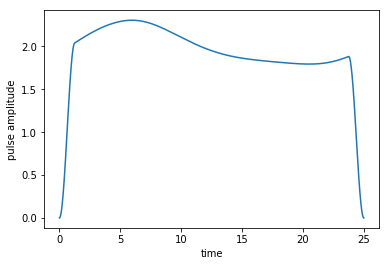

In [22]:
plot_pulse(oct_result.optimized_controls[0], tlist)

Plot the dynamics under the optimized field.

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


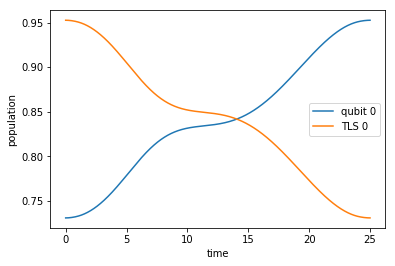

In [23]:
optimized_dynamics = oct_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj_00, proj_01, proj_10, proj_11])

plot_population(optimized_dynamics)